The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


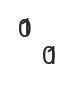

In [27]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nnq import functional as F
mpl.rcParams['figure.dpi'] = 180

## check dataset / mask behaviour

In [4]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
viral = pd.read_csv('../data/other/viral.csv').rename(columns={'sequence':'Peptide'})
drb = pd.read_csv('../data/NetMHCIIpan_train/drb1_0301.csv')

In [65]:
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
drb_loader, drb_dataset = get_NNAlign_dataloader(drb, max_len=20, window_size=9, encoding='BL50LO', seq_col='Sequence', target_col='target', pad_scale=-15, return_dataset=True)
x_tensor, y = drb_dataset[:10]
x_mask = drb_dataset.mask[:10]

In [66]:
# Make sure that the mask makes sense
x_mask, display(drb_dataset.df.iloc[:10])

,Sequence,target,HLA,to_prune,len,fold
1,AASSLTVDVTPPTAKAPT,1,Abelin__MAPTAC_DRB1_0301,False,18,0
2,ADKARKKLLADQAEARRS,1,Abelin__MAPTAC_DRB1_0301,False,18,0
3,ADKARKKLLADQAEARRSKT,1,Abelin__MAPTAC_DRB1_0301,False,20,0
4,AENLEQLIDQKLKDYEDLR,1,Abelin__MAPTAC_DRB1_0301,False,19,0
5,AENVLVADKRLIRQNKPE,1,Abelin__MAPTAC_DRB1_0301,False,18,0
6,AENVLVADKRLIRQNKPEN,1,Abelin__MAPTAC_DRB1_0301,False,19,0
7,AEQDPNVQVDHLNLLKQFE,1,Abelin__MAPTAC_DRB1_0301,False,19,0
8,AEQDPNVQVDHLNLLKQFEH,1,Abelin__MAPTAC_DRB1_0301,False,20,0
9,AGIQVVGDDLTVTNPK,1,Abelin__MAPTAC_DRB1_0301,False,16,0
10,AIEIDIPVVSHTT,1,Abelin__MAPTAC_DRB1_0301,False,13,0


(tensor([ 9,  9, 11, 10,  9, 10, 10, 11,  7,  4]), None)

In [49]:
# some checks here : Checking that for the last sample reshaped to kmers, after the max idx (4), it starts being padded (i.e. for idx 5, -15 values appear)
x_tensor[-1].view(20-9+1, 9, 20)[4], x_tensor[-1].view(20-9+1, 9, 20)[5]

(tensor([[-2., -2.,  2.,  8., -4.,  0.,  2., -1., -1., -4., -4., -1., -4., -5.,
          -1.,  0., -1., -5., -3., -4.],
         [-1., -4., -3., -4., -2., -3., -4., -4., -4.,  5.,  2., -3.,  2.,  0.,
          -3., -3., -1., -3., -1.,  4.],
         [-1., -3., -2., -1., -4., -1., -1., -2., -2., -3., -4., -1., -3., -4.,
          10., -1., -1., -4., -3., -3.],
         [ 0., -3., -3., -4., -1., -3., -3., -4., -4.,  4.,  1., -3.,  1., -1.,
          -3., -2.,  0., -3., -1.,  5.],
         [ 0., -3., -3., -4., -1., -3., -3., -4., -4.,  4.,  1., -3.,  1., -1.,
          -3., -2.,  0., -3., -1.,  5.],
         [ 1., -1.,  1.,  0., -1.,  0., -1.,  0., -1., -3., -3.,  0., -2., -3.,
          -1.,  5.,  2., -4., -2., -2.],
         [-2.,  0.,  1., -1., -3.,  1.,  0., -2., 10., -4., -3.,  0., -1., -1.,
          -2., -1., -2., -3.,  2., -4.],
         [ 0., -1.,  0., -1., -1., -1., -1., -2., -2., -1., -1., -1., -1., -2.,
          -1.,  2.,  5., -3., -2.,  0.],
         [ 0., -1.,  0., -1., -1

In [67]:
# Manually create the layers so it's more flexible
window_size=9
matrix_dim=20
n_hidden=10
max_len =20

layers = nn.Sequential(nn.Linear(window_size*matrix_dim, n_hidden), nn.ReLU(), nn.Linear(n_hidden,1))

z = layers(x_tensor)
# z = output of nnalign, before the index selection, of shape (N, max_len-window_size+1, 1)

print(z.shape)
# Need the mask can be a 0, 1 mask based on the shape and just set values where it's not allowed to 0

# here, the old index selection process:
max_idx = z.argmax(dim=1).unsqueeze(1)

torch.Size([10, 12, 1])


In [68]:
x_mask.shape

torch.Size([10])

In [ ]:
range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x_tensor), 1)

# Create a mask tensor by comparing the range_tensor with x_idx
x_mask = (range_tensor <= x_mask.unsqueeze(1)).type(torch.float32).unsqueeze(-1)
x_mask.shape
# put this in dataloader.

## Change forward pass behaviour to use mask and set values to 0

In [104]:
# Reload now that it has been saved
max_len=20
window_size=9

drb_loader, drb_dataset = get_NNAlign_dataloader(drb, max_len, window_size, encoding='BL50LO', seq_col='Sequence', target_col='target', pad_scale=-15, return_dataset=True)
x_tensor, y = drb_dataset[:10]
x_mask = drb_dataset.x_mask[:10]

In [ ]:
# idx_tensor = torch.from_numpy(drb_dataset.df.iloc[:10].len.values - window_size)
# range_tensor = torch.arange(max_len-window_size+1).unsqueeze(0).repeat(len(idx_tensor),1)
# x_mask = (range_tensor <= idx_tensor.unsqueeze(1)).float().unsqueeze(-1)
# x_mask[x_mask==0] = np.nan # CAN'T USE NAN
# x_mask

tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [nan],
         [nan]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [nan],
         [nan]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [nan]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [nan],
         [nan]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.],
        

In [105]:
# Layers before kmers selection
z = layers(x_tensor)
# Set pad to 0 so we don't choose it in the argmax
z = torch.mul(z, x_mask)
print(z)
# If all predicted scores are negatives, then 0 won't work
# Need to change the mask value from 0 to something big like -100 
# AH but ^^^ won't work because it's a multiplicatino so neg * neg = pos -> argmax
# Need to instead 

tensor([[[-0.7512],
         [-0.1905],
         [-0.2990],
         [-0.0378],
         [-0.7739],
         [-0.6918],
         [-0.9964],
         [-0.6508],
         [-0.4351],
         [-0.5287],
         [-0.0000],
         [-0.0000]],

        [[-0.4063],
         [ 0.0475],
         [ 0.0547],
         [-0.4891],
         [-0.5838],
         [-0.1157],
         [-0.1502],
         [ 0.1070],
         [-0.7162],
         [-0.8585],
         [-0.0000],
         [-0.0000]],

        [[-0.4063],
         [ 0.0475],
         [ 0.0547],
         [-0.4891],
         [-0.5838],
         [-0.1157],
         [-0.1502],
         [ 0.1070],
         [-0.7162],
         [-0.8585],
         [-0.1079],
         [-0.5655]],

        [[-0.4419],
         [-0.8502],
         [ 0.0087],
         [-1.0176],
         [ 0.0956],
         [-0.2731],
         [-0.8548],
         [-0.7071],
         [-0.5249],
         [-0.6030],
         [ 0.1683],
         [-0.0000]],

        [[-0.7915],
         [-0

In [188]:
# NEVERMIND THIS IS STUPID. JUST DO A SIGMOID TO SET TO 0,1 (ONLY FOR selection)
max_len=20
window_size=9
matrix_dim=20
n_hidden=10
# Set pad to something ridiculous to bugcheck
pad_scale = -300

layers = nn.Sequential(nn.Linear(window_size*matrix_dim, n_hidden), nn.ReLU(), nn.Linear(n_hidden,1))
drb_loader, drb_dataset = get_NNAlign_dataloader(drb, max_len, window_size, encoding='BL50LO', seq_col='Sequence', target_col='target', pad_scale=pad_scale, return_dataset=True)
x_tensor, x_mask, y = drb_dataset[:10]
x_mask = drb_dataset.x_mask[:10]

z = layers(x_tensor)
print(z.shape)
with torch.no_grad():
    xd = torch.mul(F.sigmoid(z), x_mask)
    max_idx = xd.argmax(dim=1).unsqueeze(1)
z = torch.gather(z, 1, max_idx).squeeze(1)
print(z.shape)

torch.Size([10, 12, 1])
torch.Size([10, 1])


In [189]:
print(x_tensor.shape, x_mask.shape)
print(max_idx.flatten())
print(idx_tensor)

torch.Size([10, 12, 180]) torch.Size([10, 12, 1])
tensor([ 3,  4, 11,  2,  8,  8,  1,  1,  6,  4])
tensor([ 9,  9, 11, 10,  9, 10, 10, 11,  7,  4])


# Need to also fix the behaviour for standardizer.fit

Otherwise, the pad values will affect the computation of the mean/std

In [190]:
from src.models import Standardizer
std = Standardizer()
std.fit(x_tensor)
std.mu.shape, std.sigma.shape
std.mu

tensor([ -0.2333,  -1.2583,  -0.7167,  -0.5750,  -2.3250,  -0.2000,  -0.4500,
         -2.0000,  -1.3583,  -0.9417,  -1.1500,  -0.5417,  -0.7250,  -2.4917,
         -1.4333,  -0.5833,  -0.4583,  -3.0833,  -1.6667,  -0.7083,  -0.6250,
         -1.0250,  -0.5500,  -0.4750,  -2.4083,  -0.1250,  -0.4000,  -2.1167,
         -1.2583,  -1.0417,  -1.1833,  -0.4000,  -0.7667,  -2.4917,  -1.4833,
         -0.6000,  -0.3583,  -3.1000,  -1.6500,  -0.8333,  -3.1333,  -3.4917,
         -3.0500,  -3.1000,  -4.8583,  -2.5500,  -3.0250,  -4.6667,  -3.7250,
         -3.4583,  -3.5417,  -2.8917,  -3.1417,  -4.9250,  -4.0083,  -3.0917,
         -2.8333,  -5.5167,  -4.0917,  -3.2833,  -5.5667,  -6.1000,  -5.7083,
         -5.7250,  -7.3250,  -5.2417,  -5.6667,  -7.1667,  -6.2917,  -5.8583,
         -5.9083,  -5.5500,  -5.5833,  -7.2750,  -6.4500,  -5.6667,  -5.3500,
         -7.9583,  -6.5083,  -5.6917,  -8.1333,  -8.2000,  -8.1500,  -8.2667,
         -9.8833,  -7.5833,  -8.0000,  -9.6583,  -8.6333,  -8.58

In [195]:
import torch
N=10
K=9
# Assuming you have tensors `x_values` and `x_mask`
# Apply the mask to the data
masked_values = x_tensor * x_mask
# Calculate the mean along the second dimension (M) while considering the mask
mu = torch.sum(masked_values, dim=1) / torch.sum(x_mask, dim=1)

# Calculate the standard deviation along the second dimension (M) while considering the mask
sigma = torch.sqrt(torch.sum((masked_values - mu.unsqueeze(1))**2, dim=1) / torch.sum(x_mask, dim=1))


In [201]:
mu.mean(dim=0).shape

torch.Size([180])

In [162]:
x_tensor.shape, x_mask.shape, masked_values.shape

(torch.Size([10, 12, 180]), torch.Size([10, 12, 1]), torch.Size([10, 12, 180]))

In [207]:
sigma

tensor([[2.3426, 1.1883, 1.9204,  ..., 1.5453, 1.1524, 2.3891],
        [3.0450, 3.3118, 1.7889,  ..., 1.6733, 0.9940, 1.8407],
        [2.8711, 3.0946, 1.7951,  ..., 0.9129, 0.5951, 1.6499],
        ...,
        [1.8409, 1.4977, 2.8419,  ..., 1.4434, 1.9791, 2.7221],
        [1.9665, 2.1920, 1.8708,  ..., 2.5357, 1.5811, 2.8709],
        [2.5298, 3.2100, 2.2361,  ..., 3.8074, 1.9494, 3.0027]])

In [206]:
sigma.mean(0)

tensor([2.3406, 2.4169, 2.4086, 3.7264, 1.5145, 2.3778, 2.4838, 2.0979, 2.1879,
        2.9909, 2.7881, 2.3801, 2.0905, 2.1719, 1.8929, 1.5481, 0.7993, 1.7830,
        1.1958, 2.9044, 1.5985, 2.5046, 2.6202, 3.9878, 1.5647, 2.4439, 2.6151,
        2.1531, 2.2632, 3.1892, 3.0274, 2.4758, 2.2677, 2.2516, 2.2184, 1.6217,
        0.8113, 1.8353, 1.2025, 3.0472, 1.5244, 2.5862, 2.6926, 3.7969, 1.6155,
        2.4992, 2.3123, 2.0440, 2.2614, 3.1448, 3.1797, 2.5062, 2.3114, 2.3492,
        2.5845, 1.6511, 0.8061, 1.8333, 1.2176, 3.0148, 1.5838, 2.6453, 2.4218,
        3.8930, 1.6098, 2.5149, 2.2535, 2.0439, 2.3002, 3.1263, 3.1898, 2.4805,
        2.3339, 2.3356, 2.6177, 1.6356, 0.9321, 1.8204, 1.2087, 3.0361, 1.5949,
        2.6951, 2.5313, 3.7704, 1.5586, 2.4666, 2.2784, 2.0458, 2.3219, 3.0703,
        3.1797, 2.5421, 2.2904, 2.3817, 2.6302, 1.5600, 0.9185, 1.8522, 1.3950,
        2.9983, 1.5710, 2.6732, 2.5572, 3.5970, 1.4608, 2.5465, 2.2745, 1.9976,
        2.3033, 3.0026, 2.9692, 2.7580, 

In [208]:
# fixed I guess?..

# Reading DRB1_0301 results

In [232]:
# Done with motif length 9
from sklearn.metrics import roc_auc_score, roc_curve
def get_motif(row):
    return row['Sequence'][int(row['core_start_index']):int(row['core_start_index'])+9]

PATH = '../output/230525_FixedPadding_MHCII_DRB1_0301_kcvs/'
dirs = list(filter(lambda x: 'Fixed' in x, os.listdir(PATH)))
preds = []
for dnms in dirs:
    preds.append(pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}"))
preds = pd.concat(preds)
preds['motif'] = preds.apply(get_motif, axis=1)


In [233]:
preds['motif_len'] = preds['motif'].apply(len)
preds.groupby(['motif_len', 'target']).agg(count=('Sequence','count'))

count
motif_len target       
9         0       20927
          1        2323

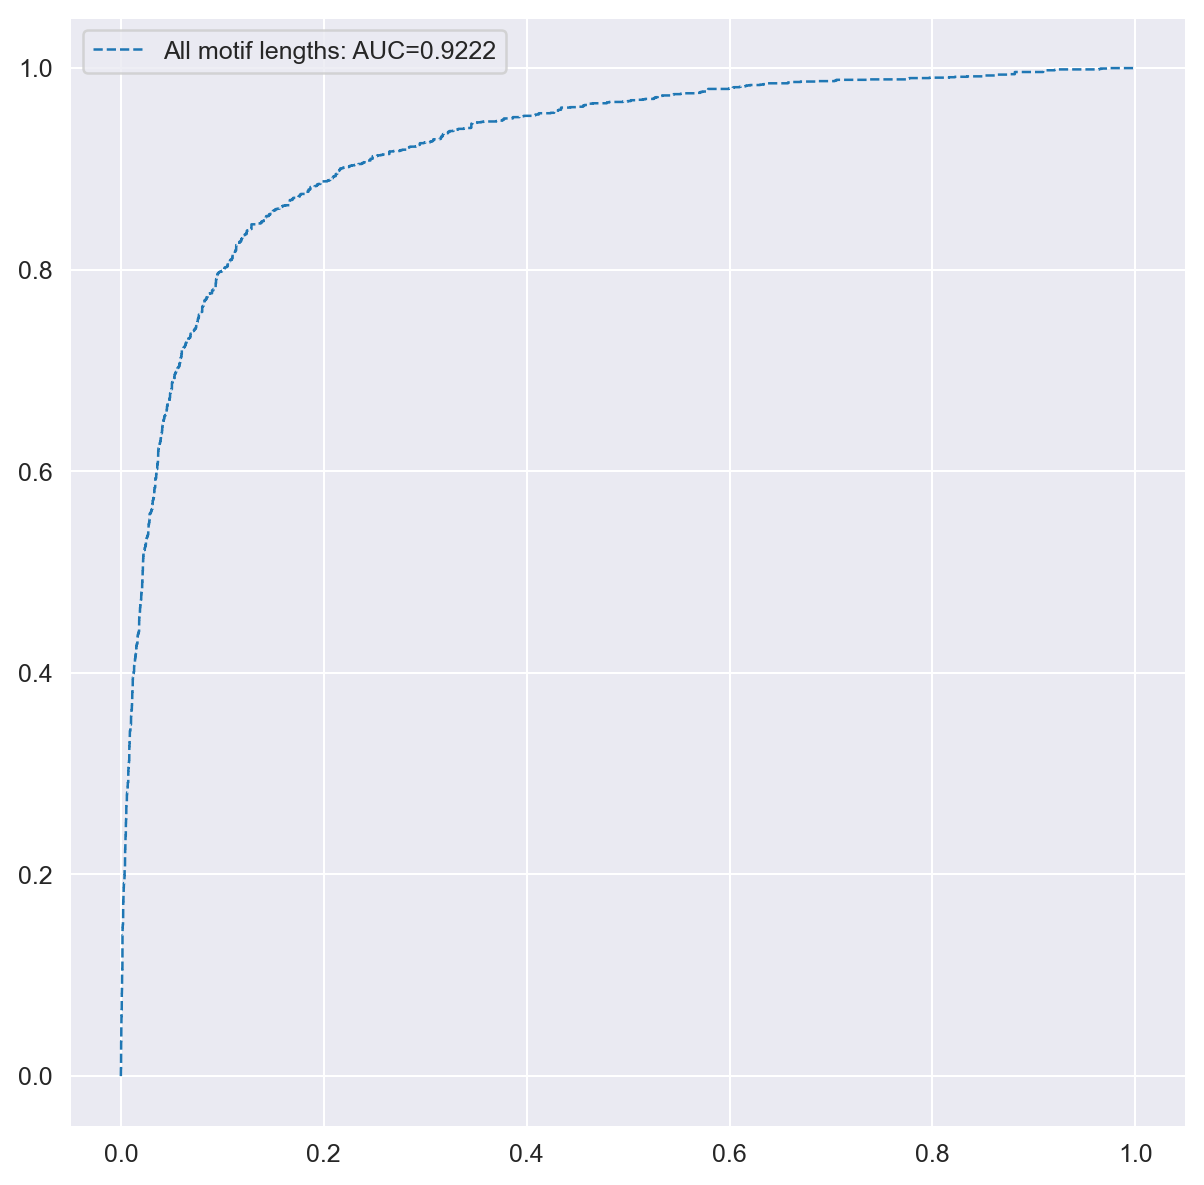

In [234]:
f,a = plt.subplots(1,1, figsize=(8,8))
auc = roc_auc_score(preds['label'].astype(int), preds['pred'])
fpr, tpr, _ = roc_curve(preds['label'].astype(int), preds['pred'])
sns.lineplot(x=fpr, y=tpr, label=f'All motif lengths: AUC={auc:.4f}', estimator = None, ls='--', lw=1, ax=a)

# auc = roc_auc_score(preds.query('motif_len!=9')['label'].astype(int), preds.query('motif_len!=9')['pred'])
# fpr, tpr, _ = roc_curve(preds.query('motif_len!=9')['label'].astype(int), preds.query('motif_len!=9')['pred'])
# sns.lineplot(x=fpr, y=tpr, label=f'Non 9mers motifs: AUC={auc:.4f}', estimator=None, ls='--', lw=1, ax=a)


# auc = roc_auc_score(preds.query('motif_len==9')['label'].astype(int), preds.query('motif_len==9')['pred'])
# fpr, tpr, _ = roc_curve(preds.query('motif_len==9')['label'].astype(int), preds.query('motif_len==9')['pred'])
# sns.lineplot(x=fpr, y=tpr, label=f'only 9mers motifs: AUC={auc:.4f}', estimator=None,ls='--', lw=1,  ax=a)
# a.set_title('My model does something wrong sometimes\nand selects the wrong motif lengths (because of padding)')
f.savefig(f'{PATH}roc_curve_valid.png', dpi=300, bbox_inches='tight')

In [235]:
preds.query('label==1')['motif'].to_csv(f'{PATH}pred_motif_binders.txt', index=False,header=None)
preds.query('label==0')['motif'].to_csv(f'{PATH}pred_motif_non_binders.txt', index=False,header=None)
preds['motif'].to_csv(f'{PATH}pred_motif_both.txt', index=False,header=None)


# Redone with No STD

In [239]:
# Done with motif length 9
from sklearn.metrics import roc_auc_score, roc_curve
def get_motif(row):
    return row['Sequence'][int(row['core_start_index']):int(row['core_start_index'])+9]

PATH = '../output/230525_NOSTD_FixedPadding_MHCII_DRB1_0301_kcvs/'
dirs = list(filter(lambda x: 'Fixed' in x, os.listdir(PATH)))
preds = []
for dnms in dirs:
    preds.append(pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}"))
preds = pd.concat(preds)
preds['motif'] = preds.apply(get_motif, axis=1)


In [228]:
preds['motif_len'] = preds['motif'].apply(len)
preds.groupby(['motif_len', 'target']).agg(count=('Sequence','count'))

count
motif_len target       
9         0       20927
          1        2323

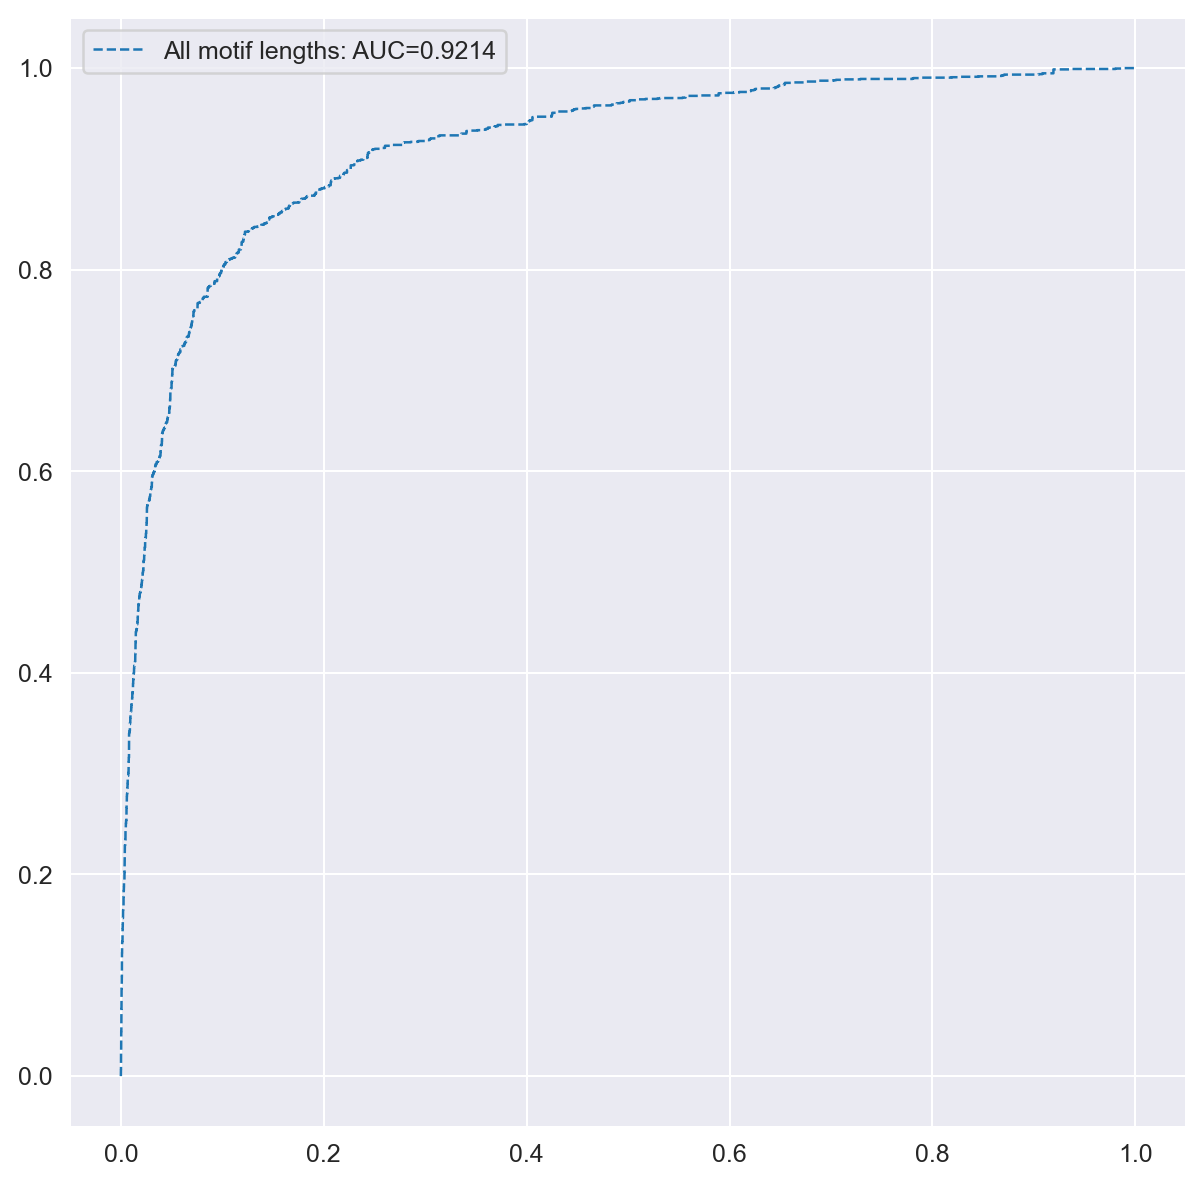

In [230]:
f,a = plt.subplots(1,1, figsize=(8,8))
auc = roc_auc_score(preds['label'].astype(int), preds['pred'])
fpr, tpr, _ = roc_curve(preds['label'].astype(int), preds['pred'])
sns.lineplot(x=fpr, y=tpr, label=f'All motif lengths: AUC={auc:.4f}', estimator = None, ls='--', lw=1, ax=a)
f.savefig(f'{PATH}roc_curve_valid.png', dpi=300, bbox_inches='tight')

In [231]:
preds.query('label==1')['motif'].to_csv(f'{PATH}pred_motif_binders.txt', index=False,header=None)
preds.query('label==0')['motif'].to_csv(f'{PATH}pred_motif_non_binders.txt', index=False,header=None)
preds['motif'].to_csv(f'{PATH}pred_motif_both.txt', index=False,header=None)
